In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltp
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load electricity_data
electricity_data = pd.read_csv('./raw/electricity_data.csv')

#Create an average temp from the min and max temp
electricity_data['avg_temp'] = (electricity_data['min_temperature'] + electricity_data['max_temperature']) / 2

#Convert date to datetime
electricity_data['date'] = pd.to_datetime(electricity_data['date'], format='%Y-%m-%d')

#Create year,month,dayofyear columns from the date column
electricity_data.loc[:, 'year'] = electricity_data['date'].dt.year
electricity_data.loc[:, 'month'] = electricity_data['date'].dt.month
electricity_data.loc[:, 'dayofyear'] = electricity_data['date'].dt.dayofyear

#Replace Y/N in holiday/school_day column with 1/0. 1 meaning Y and 0 meaning N
electricity_data['holiday'] = electricity_data['holiday'].replace({'Y': 1, 'N': 0})
electricity_data['school_day'] = electricity_data['school_day'].replace({'Y': 1, 'N': 0})

#Remove missing data from the solar_exposure column
electricity_data.dropna(subset=['solar_exposure'], inplace=True) 

#Drop irrelevant columns
electricity_data.drop(['RRP', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'rainfall'], axis=1, inplace=True)

#Print columns
electricity_data.head()

C:\Users\Leoho\AppData\Local\Temp\ipykernel_35040\298395900.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  electricity_data['holiday'] = electricity_data['holiday'].replace({'Y': 1, 'N': 0})
C:\Users\Leoho\AppData\Local\Temp\ipykernel_35040\298395900.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  electricity_data['school_day'] = electricity_data['school_day'].replace({'Y': 1, 'N': 0})


,date,demand,min_temperature,max_temperature,solar_exposure,school_day,holiday,avg_temp,year,month,dayofyear
0,2015-01-01,99635.030,13.3,26.9,23.6,0,1,20.10,2015,1,1
1,2015-01-02,129606.010,15.4,38.8,26.8,0,0,27.10,2015,1,2
2,2015-01-03,142300.540,20.0,38.2,26.5,0,0,29.10,2015,1,3
3,2015-01-04,104330.715,16.3,21.4,25.2,0,0,18.85,2015,1,4
4,2015-01-05,118132.200,15.0,22.0,30.7,0,0,18.50,2015,1,5


**Plotting Data**

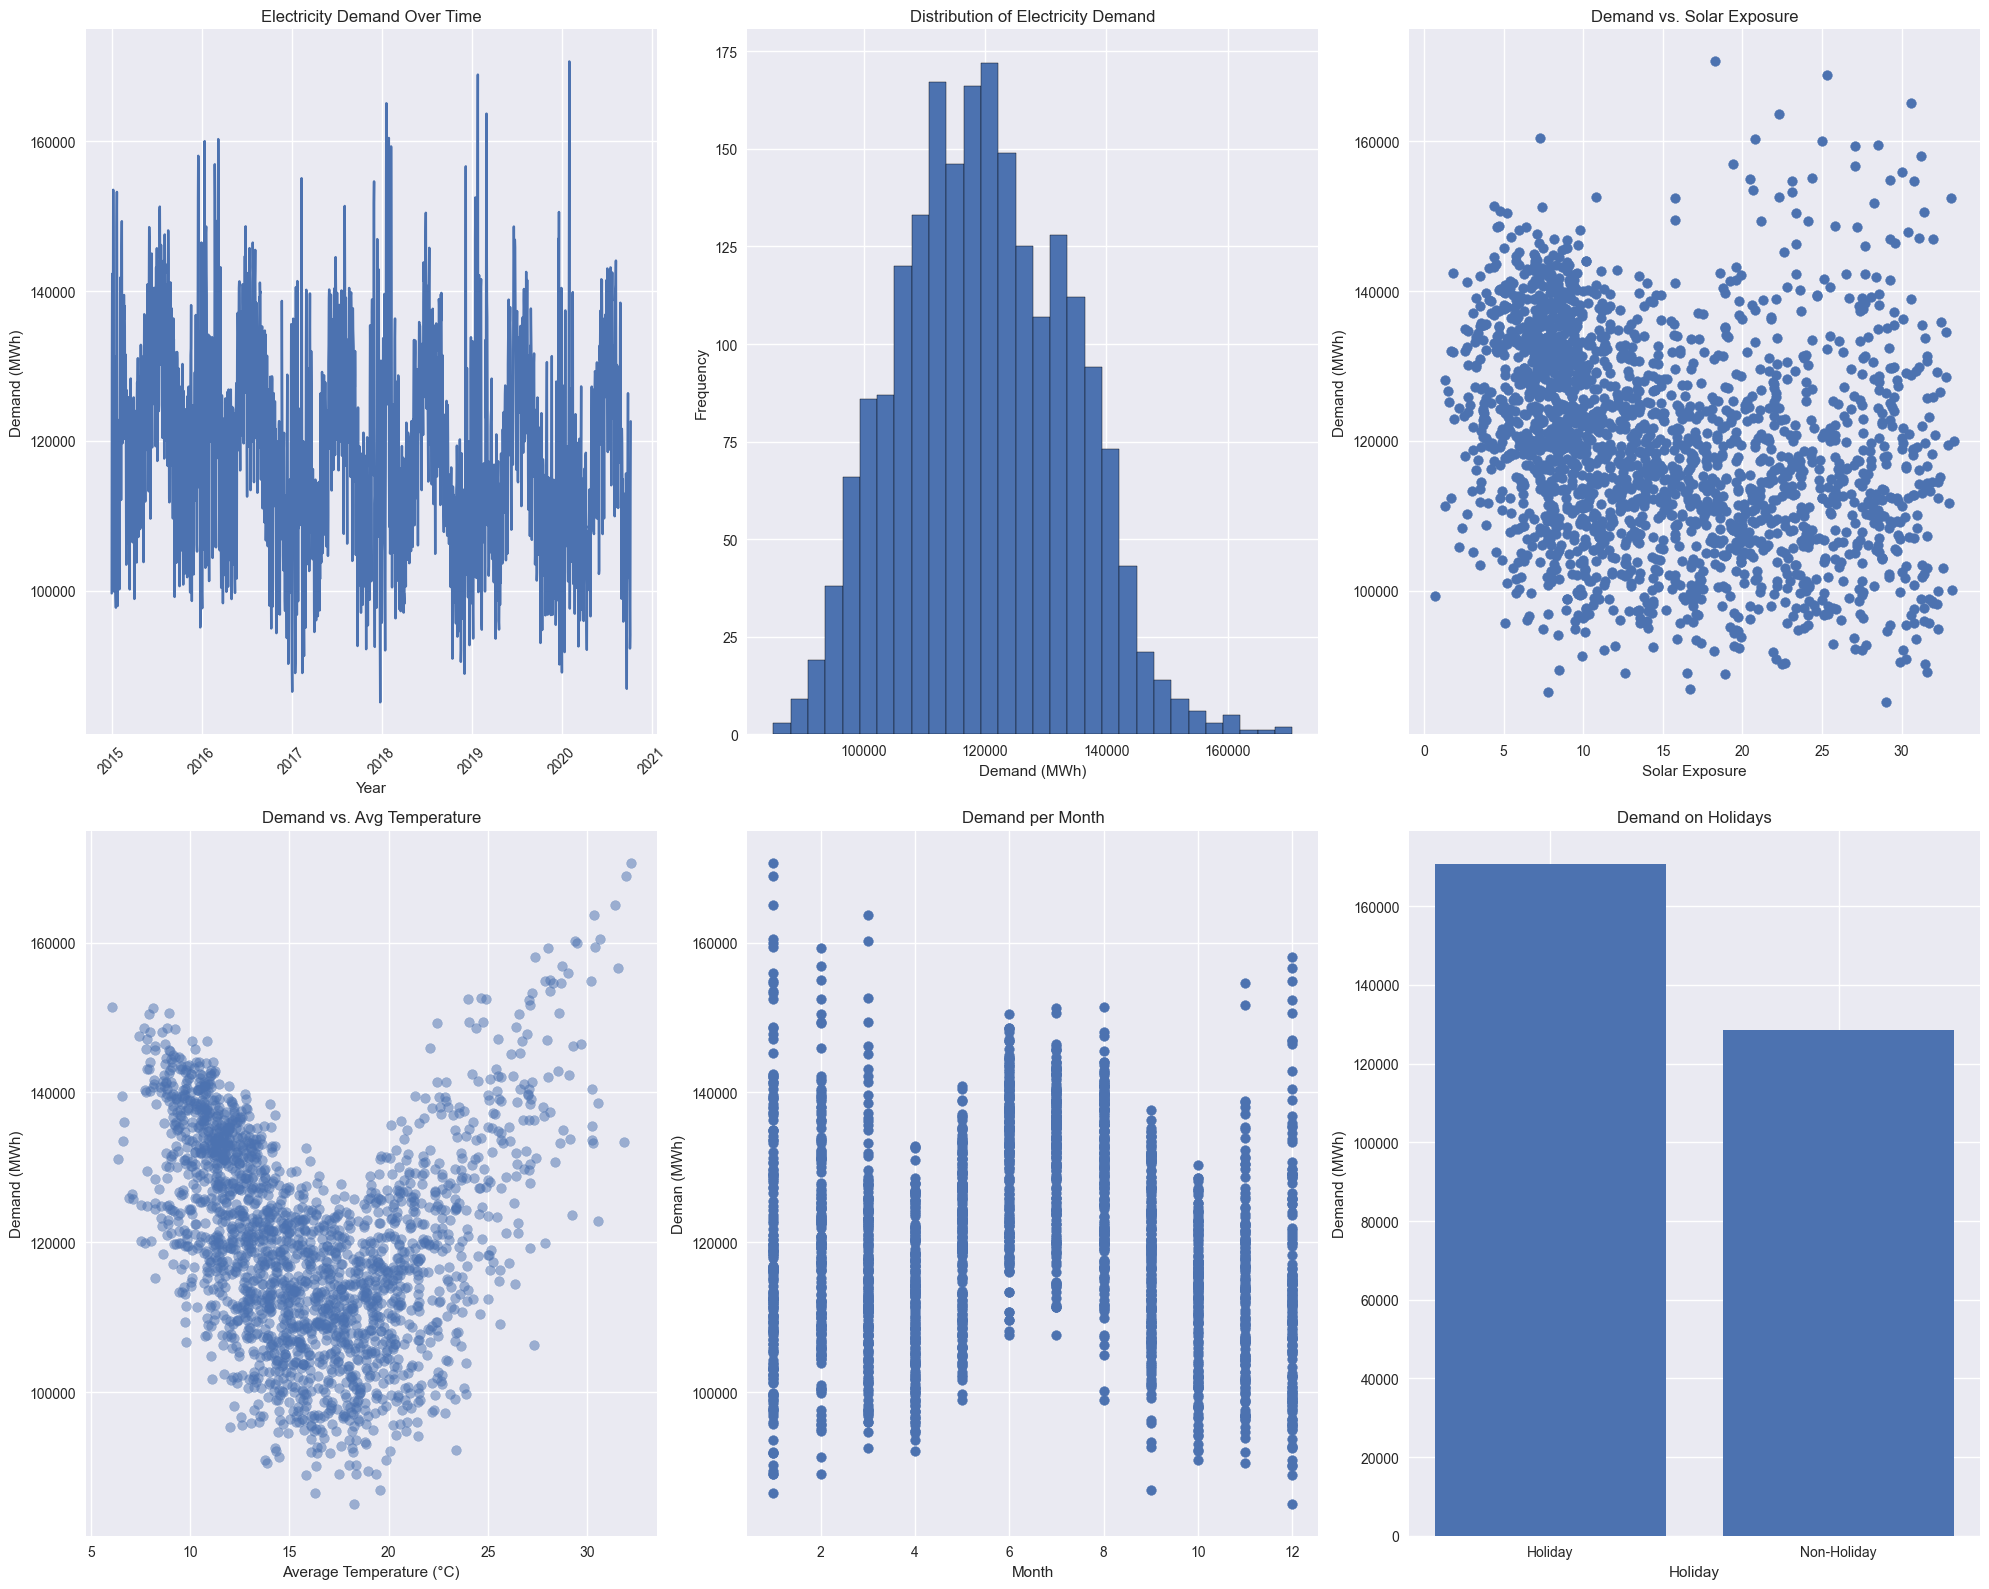

In [ ]:


#Set up the plotting style and subplots
pltp.style.use('seaborn-v0_8')
fig, axes = pltp.subplots(2, 3, figsize=(20, 16))

#Plot the electricity demand over time
axes[0, 0].plot(electricity_data['date'], electricity_data['demand'])
axes[0, 0].set_title('Electricity Demand Over Time')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Demand (MWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

#Plot the average distribution of demand
axes[0, 1].hist(electricity_data['demand'], bins=30, edgecolor='black')
axes[0, 1].set_title('Distribution of Electricity Demand')
axes[0, 1].set_xlabel('Demand (MWh)')
axes[0, 1].set_ylabel('Frequency')

#Plot the demand vs the solar exposure
axes[0, 2].scatter(electricity_data['solar_exposure'], electricity_data['demand'])
axes[0, 2].set_title('Demand vs. Solar Exposure')
axes[0, 2].set_ylabel('Demand (MWh)')
axes[0, 2].set_xlabel('Solar Exposure')

#Plot the demand vs the avg temp
axes[1, 0].scatter(electricity_data['avg_temp'], electricity_data['demand'], alpha=0.5)
axes[1, 0].set_title('Demand vs. Avg Temperature')
axes[1, 0].set_xlabel('Average Temperature (°C)')
axes[1, 0].set_ylabel('Demand (MWh)')

#Plot the demand per month
axes[1, 1].scatter( electricity_data['month'], electricity_data['demand'])
axes[1, 1].set_title('Demand per Month')
axes[1, 1].set_ylabel('Deman (MWh)')
axes[1, 1].set_xlabel('Month')

#Plot the demand on holidays vs non holidays
axes[1, 2].bar(electricity_data['holiday'], electricity_data['demand'])
axes[1, 2].set_title('Demand on Holidays')
axes[1, 2].set_ylabel('Demand (MWh)')
axes[1, 2].set_xlabel('Holiday')
axes[1, 2].set_xticks(ticks=[1, 0], labels=['Non-Holiday', 'Holiday'])



pltp.tight_layout()
pltp.show()

**Random Forest Regression**

Random Forest root Mean squared error: 9322.497383166456
Random Forest R-squared score: 0.5654985417053273
avg_temp: 0.5473131546011761
holiday: 0.03134719252550173
solar_exposure: 0.15247824409594338
dayofyear: 0.17165476615895067
year: 0.0818961401267136
month: 0.015310502491714643


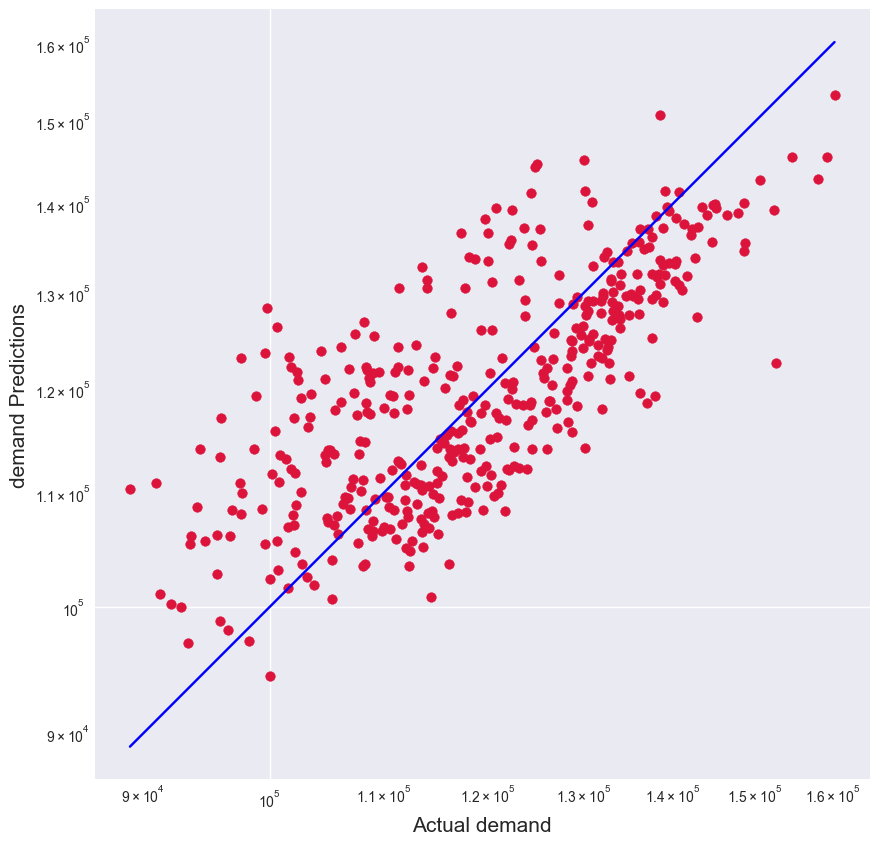

In [3]:
from sklearn.metrics import root_mean_squared_error

#Select features and target
features = [ 'avg_temp', 'holiday', 'solar_exposure', 'dayofyear','year','month']
RFX = electricity_data[features]
RFy = electricity_data['demand'].values.astype("float64")

#Split the data
RFX_train, RFX_test, RFy_train, RFy_test = train_test_split(RFX, RFy, test_size=0.2, random_state=42)

#Create and train the model using training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(RFX_train, RFy_train)

#Make predictions using the test data
y_pred = model.predict(RFX_test)

#Evaluate the model using RMSE and R2 scores
RFrmse = root_mean_squared_error(RFy_test, y_pred)
RFr2 = r2_score(RFy_test, y_pred)

print(f"Random Forest root Mean squared error: {RFrmse}")
print(f"Random Forest R-squared score: {RFr2}")

#Display features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted vs true values
pltp.figure(figsize=(10,10))
pltp.scatter(RFy_test, y_pred, c='crimson')
pltp.yscale('log')
pltp.xscale('log')

p1 = max(max(y_pred), max(RFy_test))
p2 = min(min(y_pred), min(RFy_test))
pltp.plot([p1, p2], [p1, p2], 'b-')
pltp.xlabel('Actual demand', fontsize=15)
pltp.ylabel('demand Predictions', fontsize=15)
pltp.axis('equal')
pltp.show()

**XGBoost Regressor**

XGBoost root Mean squared error: 9537.449693985463
XGBoost R-squared score: 0.5452306168160599
avg_temp: 0.3983514904975891
solar_exposure: 0.2430526316165924
holiday: 0.15177585184574127
year: 0.07770131528377533
dayofyear: 0.12911874055862427
month: 0.0
school_day: 0.0


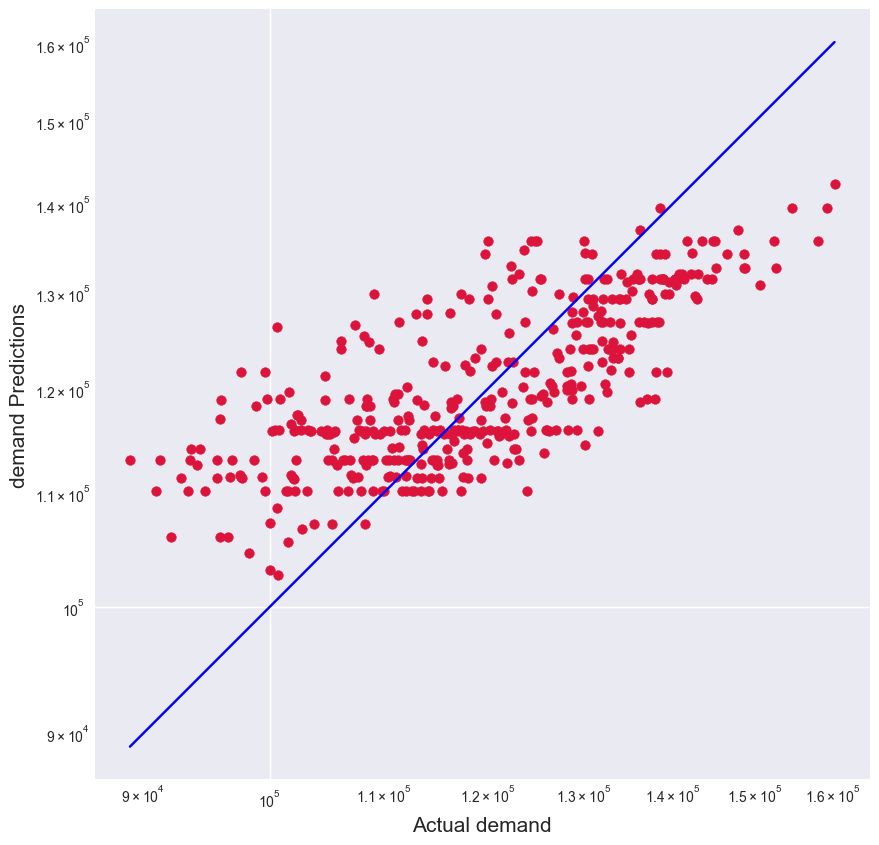

In [5]:
#Select features and target
features = ['avg_temp', 'solar_exposure', 'holiday', 'year', 'dayofyear', 'month', 'school_day']
GBRX = electricity_data[features]
GBRy = electricity_data['demand'].values

#Split the data
GBRX_train, GBRX_test, GBRy_train, GBRy_test = train_test_split(GBRX, GBRy, test_size=0.2, random_state=42)

#Create and train the model using training data, specifying the learning objective
model = XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=2, random_state=42)
model.fit(GBRX_train, GBRy_train)

#Make predictions using the testing data
GBRy_pred = model.predict(GBRX_test)

#Evaluate the model using RMSE and R2 scores
GBRmse = root_mean_squared_error(GBRy_test, GBRy_pred)
GBRr2 = r2_score(GBRy_test, GBRy_pred)

print(f"XGBoost root Mean squared error: {GBRmse}")
print(f"XGBoost R-squared score: {GBRr2}")

#Display features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted vs true values
pltp.figure(figsize=(10,10))
pltp.scatter(GBRy_test, GBRy_pred, c='crimson')
pltp.yscale('log')
pltp.xscale('log')

p1 = max(max(GBRy_pred), max(GBRy_test))
p2 = min(min(GBRy_pred), min(GBRy_test))
pltp.plot([p1, p2], [p1, p2], 'b-')
pltp.xlabel('Actual demand', fontsize=15)
pltp.ylabel('demand Predictions', fontsize=15)
pltp.axis('equal')
pltp.show()
